# Employee Attrition Prediction

### Problem Statement

In recent years, attention has increasingly been paid to human resources (HR), since worker quality and skills represent a growth factor and a real competitive advantage for companies. After proving its mettle in sales and marketing, artificial intelligence is also becoming central to employee-related decisions within HR management. Organizational growth largely depends on staff retention. Losing employees frequently impacts the morale of the organization and hiring new employees is more expensive than retaining existing ones. 

You are working as a data scientist with HR Department of a large insurance company focused on sales team attrition. Insurance sales teams help insurance companies generate new business by contacting potential customers and selling one or more types of insurance. The department generally sees high attrition and thus staffing becomes a crucial aspect. 

To aid staffing, you are provided with the monthly information for a segment of employees for 2016 and 2017 and tasked to predict whether a current employee will be leaving the organization in the upcoming two quarters (01 Jan 2018 - 01 July 2018) or not, given:


1. Demographics of the employee (city, age, gender etc.)
2. Tenure information (joining date, Last Date)
3. Historical data regarding the performance of the employee (Quarterly rating, Monthly business acquired, designation, salary)

#### Table Of Contents

1.Import Libraries

2.Exploratory Data Analysis

3.Feature Engineering

4.Model Building

5.Hyper Parameter Tuning & Optimization

6.Validation with the test set

7.Submission

###### Import Libraries

In [130]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import functools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score,ShuffleSplit,RandomizedSearchCV
from sklearn.metrics import confusion_matrix,classification_report,f1_score,roc_auc_score,accuracy_score
from sklearn.metrics import precision_score,recall_score

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 2000)
plt.rcParams['figure.figsize']=(4,4)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%config IPCompleter.greedy=True
%matplotlib inline
np.random.seed(seed=12)

###### Data Inspection

In [131]:
train=pd.read_csv('train_MpHjUjU.csv')
test=pd.read_csv('test_hXY9mYw.csv')

In [142]:
test.head()

,Emp_ID
0,394
1,173
2,1090
3,840
4,308


In [51]:
train.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1


##### Variable Description

MMMM-YY : Reporting Date (Monthly)
    
Emp_ID : Unique id for employees
    
Age : Age of the employee
    
Gender : Gender of the employee
    
City : City Code of the employee
    
Education_Level : Education level : Bachelor, Master or College
        
Salary : Salary of the employee
    
Dateofjoining : Joining date for the employee
    
LastWorkingDate : Last date of working for the employee
    
Joining Designation : Designation of the employee at the time of joining
    
Designation : Designation of the employee at the time of reporting
    
Total_Business_Value : The total business value acquired by the employee in a month
(negative business indicates cancellation/refund of sold insurance policies)  

Quarterly Rating : Quarterly rating of the employee: 1,2,3,4 (higher is better)


In [52]:
# Nos of rows and columns in the dataset
train.shape

(19104, 13)

In [53]:
test.shape

(741, 1)

#### Exploratory Data Analysis

In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MMM-YY                19104 non-null  object
 1   Emp_ID                19104 non-null  int64 
 2   Age                   19104 non-null  int64 
 3   Gender                19104 non-null  object
 4   City                  19104 non-null  object
 5   Education_Level       19104 non-null  object
 6   Salary                19104 non-null  int64 
 7   Dateofjoining         19104 non-null  object
 8   LastWorkingDate       1616 non-null   object
 9   Joining Designation   19104 non-null  int64 
 10  Designation           19104 non-null  int64 
 11  Total Business Value  19104 non-null  int64 
 12  Quarterly Rating      19104 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.9+ MB


In [55]:
#Describing Numerical Columns
train.describe()

,Emp_ID,Age,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating
count,19104.000000,19104.000000,19104.000000,19104.000000,19104.000000,1.910400e+04,19104.000000
mean,1415.591133,34.650283,65652.025126,1.690536,2.252670,5.716621e+05,2.008899
std,810.705321,6.264471,30914.515344,0.836984,1.026512,1.128312e+06,1.009832
min,1.000000,21.000000,10747.000000,1.000000,1.000000,-6.000000e+06,1.000000
25%,710.000000,30.000000,42383.000000,1.000000,1.000000,0.000000e+00,1.000000
50%,1417.000000,34.000000,60087.000000,1.000000,2.000000,2.500000e+05,2.000000
75%,2137.000000,39.000000,83969.000000,2.000000,3.000000,6.997000e+05,3.000000
max,2788.000000,58.000000,188418.000000,5.000000,5.000000,3.374772e+07,4.000000


In [56]:
#Describing Categorical Column
train[['MMM-YY','Gender','City','Education_Level','Dateofjoining','LastWorkingDate']].describe()

,MMM-YY,Gender,City,Education_Level,Dateofjoining,LastWorkingDate
count,19104,19104,19104,19104,19104,1616
unique,24,2,29,3,869,493
top,2016-01-01,Male,C20,Bachelor,2012-07-23,2017-07-29
freq,1022,11103,1008,6864,192,70


Observation: Most of the employees in our observations are Male,the employees are mostly from C20 city and they are holding Bachelors degree. Most of the employees have joined the company in 2012 and left the company in 2017,so the employee stays with the company for minimum 5 years

In [57]:
#Find for any missing values
round(train.isna().mean()*100,2)

MMM-YY                   0.00
Emp_ID                   0.00
Age                      0.00
Gender                   0.00
City                     0.00
Education_Level          0.00
Salary                   0.00
Dateofjoining            0.00
LastWorkingDate         91.54
Joining Designation      0.00
Designation              0.00
Total Business Value     0.00
Quarterly Rating         0.00
dtype: float64

Observation:We could find missing values only in the 'LastWorkingDate' column.As the reports were generted monthly we can assume that the employees were with the company when the employee record was generated.

###### Manipulating Date field

In [132]:
train['Month'] = pd.to_datetime(train['MMM-YY']).dt.month
train['LastWorkingDate'] = pd.to_datetime(train['LastWorkingDate'])
train['Dateofjoining']=pd.to_datetime(train['Dateofjoining'])
train['DOJ-year'] = train['Dateofjoining'].dt.year
train['DOJ-quarter'] = train['Dateofjoining'].dt.quarter   

In [133]:
for i in range(len(train['LastWorkingDate'])):
    if train['LastWorkingDate'][i] != 0:
        train['LWD-year'] = train['LastWorkingDate'].dt.year
        train['LWD-quarter'] = train['LastWorkingDate'].dt.quarter        
    else:    
        train['LWD-quarter'] = train['LastWorkingDate'].fillna(0)
        train['LWD-year'] = 0

In [134]:
train['LWD-quarter'] = train['LWD-quarter'].fillna(0)
train['LWD-quarter'] = train['LWD-quarter'].astype('int64')
train['LWD-year'] = train['LWD-year'].fillna(0)
train['LWD-year'] = train['LWD-year'].astype('int64') 

In [135]:
train.head(2)

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating,Month,DOJ-year,DOJ-quarter,LWD-year,LWD-quarter
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,2381060,2,1,2015,4,0,0
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,-665480,2,2,2015,4,0,0


Approach for Date field:
    
Captured the quarter in which the employee joined the company. DOJ - Date Of Joining

In order to capture the Quarter in which employee left the company, the 'LastWorkingDate' field was converted to date field before filling the NaN values with '0', if '0' is filled before date conversion then the value '0' will be replaced by the default value '1970-01-01'. LWD : Last Working Day

Mainly concentrated to capture the quarterly data, as we are concerned about the employee attrition for the first 2 Quarters in 2018. 

In [136]:
train['LWD-year'].unique()

array([   0, 2016, 2017, 2015], dtype=int64)

###### Data Visualization

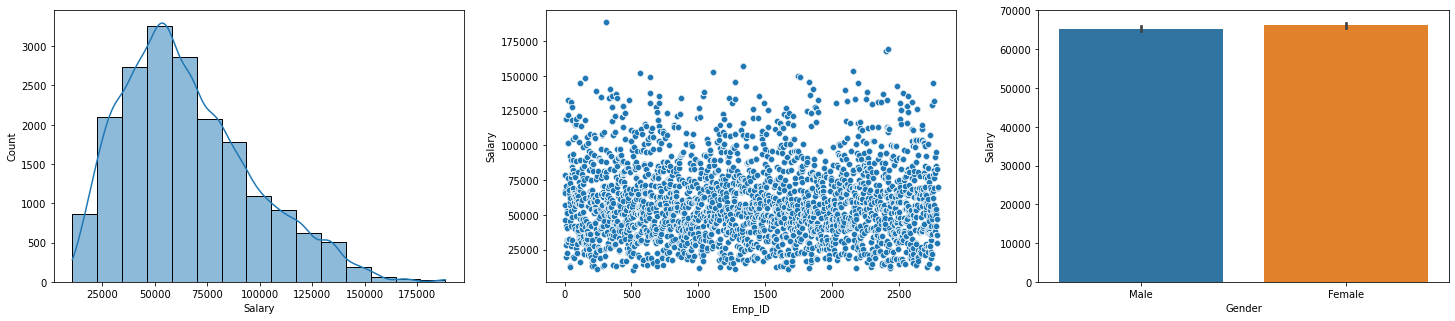

In [63]:
fig, axes=plt.subplots(1,3,figsize=(25,5))
sns.histplot(train['Salary'],bins=15,kde=True,ax=axes[0]);
sns.scatterplot(train['Emp_ID'],train['Salary'],ax=axes[1]);
sns.barplot(train['Gender'],train['Salary'],ax=axes[2]);

The Salary of the employees are mostly below 1 Lac and less than 25% of the people are having their salary above 1 Lac.So the data set seems to be slightly left skewed.There is no bias in salary between the gender.

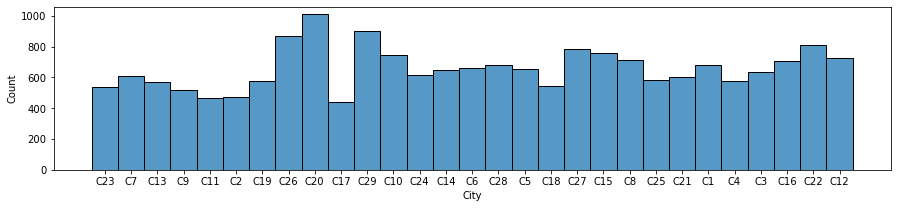

In [64]:
plt.figure(figsize=(15,3))
sns.histplot(train['City'],bins=10);

The employees of the company are from 29 cities.Most of the employees are from C20 city

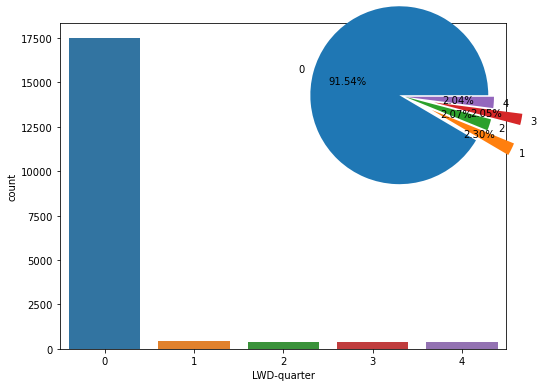

In [65]:
# Last working day feature visualization
fig=plt.figure(figsize=(8,6))
fig.add_subplot(1,1,1)
sns.countplot(train['LWD-quarter']);
fig.add_subplot(2,2,2)
plt.pie(train['LWD-quarter'].value_counts(),labels=['0','1','2','3','4'],autopct='%1.2f%%',explode=[.1,.5,0,.5,0],rotatelabels=False,radius=1.5);


##### Every Quarter the company faced 2% employee attrition

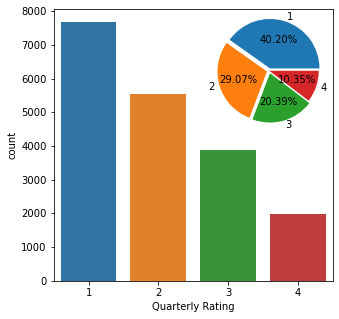

In [66]:
# Quarterly Rating feature visualization
fig=plt.figure(figsize=(5,5))
fig.add_subplot(1,1,1)
sns.countplot(train['Quarterly Rating']);
fig.add_subplot(2,2,2)
plt.pie(train['Quarterly Rating'].value_counts(),labels=['1','2','3','4'],autopct='%1.2f%%',explode=[.05,.05,.05,0]);

###### The employees quarterly ratings were mostly '1' (40% of the time), and only 10% of the time the employees received rating '4'. This shows that the employees were rewarded less and this might be the cause for attrition too.

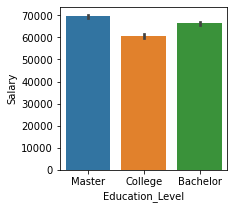

In [67]:
plt.figure(figsize=(3,3))
sns.barplot(train['Education_Level'],train['Salary']);

The employees with the 'masters' degree were given high salary.

###### LWD - Last Working Day - Quarterly

In [68]:
count_LWD=train['LWD-quarter'].value_counts()
count_LWD
train.groupby(['LWD-quarter','Quarterly Rating'])[['LWD-quarter']].count()

0    17488
1      440
4      395
3      391
2      390
Name: LWD-quarter, dtype: int64

LWD-quarter
LWD-quarter Quarterly Rating             
0           1                        6247
            2                        5407
            3                        3867
            4                        1967
1           1                         417
            2                          19
            3                           3
            4                           1
2           1                         352
            2                          31
            3                           5
            4                           2
3           1                         335
            2                          41
            3                          13
            4                           2
4           1                         328
            2                          55
            3                           7
            4                           5

###### The Attrition rate remains nearly 2% in all the quarters and that too the employee with '1' rating contributes the most for the attrition followed by '2' rated employees. The attrition rate is less among the employees rated '3' & '4' 

In [69]:
train.groupby(['LWD-year'])[['LWD-quarter']].count()

,LWD-quarter
LWD-year,
0,17488
2015,5
2016,825
2017,786


###### We could see more attrition in the year 2016 and 2017

Inference from 'Total Business Value' feature

In [70]:
train['Emp_ID'].nunique()
train[(train['Total Business Value'] < 0)==True]
train[((train['Total Business Value'] < 0)==True) & train['LWD-quarter'] != 0]

2381

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating,Month,DOJ-year,DOJ-quarter,LWD-year,LWD-quarter
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,-665480,2,2,2015,4,0,0
129,2017-04-01,25,30,Male,C24,Bachelor,102077,2014-10-30,NaT,1,3,-414250,3,4,2014,4,0,0
187,2016-11-01,36,40,Female,C18,Bachelor,32865,2016-07-01,NaT,2,2,-19350,2,11,2016,3,0,0
191,2017-03-01,36,40,Female,C18,Bachelor,32865,2016-07-01,NaT,2,2,-50000,1,3,2016,3,0,0
196,2017-08-01,36,41,Female,C18,Bachelor,32865,2016-07-01,2017-07-29,2,2,-325140,2,8,2016,3,2017,3
206,2017-03-01,38,22,Male,C27,College,13427,2016-12-06,2017-03-15,1,1,-155610,1,3,2016,4,2017,1
247,2017-09-01,45,35,Male,C8,Master,77544,2017-05-29,NaT,3,3,-58440,3,9,2017,2,0,0
339,2016-05-01,57,37,Female,C1,Bachelor,84318,2014-07-26,NaT,1,2,-157620,2,5,2014,3,0,0
383,2016-02-01,61,32,Male,C11,Master,19818,2015-05-04,NaT,1,1,-439300,1,2,2015,2,0,0
537,2016-02-01,78,35,Male,C21,College,105946,2015-09-16,NaT,2,4,-1629620,2,2,2015,3,0,0


,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating,Month,DOJ-year,DOJ-quarter,LWD-year,LWD-quarter
196,2017-08-01,36,41,Female,C18,Bachelor,32865,2016-07-01,2017-07-29,2,2,-325140,2,8,2016,3,2017,3
206,2017-03-01,38,22,Male,C27,College,13427,2016-12-06,2017-03-15,1,1,-155610,1,3,2016,4,2017,1
604,2017-09-01,84,42,Male,C16,College,25950,2016-07-04,2017-09-04,1,1,-300000,2,9,2016,3,2017,3
706,2017-07-01,103,26,Female,C28,Bachelor,68913,2016-11-30,2017-07-04,2,2,-150310,1,7,2016,4,2017,3
1206,2016-09-01,178,23,Female,C7,College,36637,2015-09-11,2016-09-26,2,2,-109200,1,9,2015,3,2016,3
4512,2017-09-01,668,29,Female,C3,Bachelor,45969,2016-11-28,2017-09-21,2,2,-14600,2,9,2016,4,2017,3
5531,2017-03-01,827,33,Male,C28,Master,67113,2016-12-13,2017-03-16,2,2,-110080,1,3,2016,4,2017,1
6017,2017-03-01,895,31,Male,C14,Master,34868,2016-09-13,2017-03-02,1,1,-262530,1,3,2016,3,2017,1
6210,2016-01-01,930,37,Female,C7,Master,37285,2015-10-16,2016-01-02,1,1,-101180,1,1,2015,4,2016,1
6370,2017-09-01,947,30,Female,C6,Bachelor,74402,2017-04-12,2017-09-19,3,3,-141140,1,9,2017,2,2017,3


Total number of employees in the company = 2381

Total number of employees who gave negative business to the company  = 139 

No of employees left the company - who gave continuous negative business for 2 quarters = 11

No of employees left the company - who gave negative business once = 7

So,we can infer from the 'Total Business Value' feature that the employees were given 2 chances to prove their importance to the company. 

We can also assume that the employee himself left the company thinking that as he did not bring business to the company he cannot expect any benefit from the company.


In [71]:
train.groupby(['LWD-quarter','Education_Level'])[['LWD-quarter']].count()

LWD-quarter
LWD-quarter Education_Level             
0           Bachelor                6337
            College                 5371
            Master                  5780
1           Bachelor                 144
            College                  159
            Master                   137
2           Bachelor                 132
            College                  134
            Master                   124
3           Bachelor                 134
            College                  121
            Master                   136
4           Bachelor                 117
            College                  128
            Master                   150

Education level did not show any change in the attrition rate.

In [72]:
train.groupby(['LWD-quarter','Joining Designation','Designation'])[['LWD-quarter']].count()

LWD-quarter
LWD-quarter Joining Designation Designation             
0           1                   1                   4606
                                2                   2340
                                3                   1373
                                4                    702
                                5                     58
            2                   2                   3687
                                3                    663
                                4                    946
                                5                     99
            3                   3                   2453
                                4                    114
                                5                      6
            4                   4                    312
                                5                      7
            5                   5                    122
1           1                   1                    224
                                2                     19
                                3                      5
                                4                      4
                                5                      1
            2                   2                    123
                                3                      8
                                4                      2
            3                   3                     46
                                4                      1
            4                   4                      7
2           1                   1                    163
                                2                     30
                                3                      6
                                4                      2
                                5                      1
            2                   2                    118
                                3                      5
                                4                      4
            3                   3                     54
            4                   4                      5
            5                   5                      2
3           1                   1                    109
                                2                     27
                                3                     12
                                4                      6
                                5                      2
            2                   2                    124
                                3                      9
                                4                     13
            3                   3                     82
                                4                      1
                                5                      1
            4                   4                      3
            5                   5                      2
4           1                   1                    100
                                2                     25
                                3                      9
                                4                      7
            2                   2                    134
                                3                     13
                                4                      7
            3                   3                     88
                                4                      1
            4                   4                      7
            5                   5                      4

WE can infer after comapring the designations that attrition rate seemed to be very less when the employees designation changed from what they had initially when they joined the organization. 

In [73]:
train.groupby(['LWD-quarter','Designation'])[['LWD-quarter']].count()

LWD-quarter
LWD-quarter Designation             
0           1                   4606
            2                   6027
            3                   4489
            4                   2074
            5                    292
1           1                    224
            2                    142
            3                     59
            4                     14
            5                      1
2           1                    163
            2                    148
            3                     65
            4                     11
            5                      3
3           1                    109
            2                    151
            3                    103
            4                     23
            5                      5
4           1                    100
            2                    159
            3                    110
            4                     22
            5                      4

Employees with the designation 4 & 5 shows very less attrition.

In [74]:
train.groupby(['LWD-quarter','Gender'])[['LWD-quarter']].count()

LWD-quarter
LWD-quarter Gender             
0           Female         7333
            Male          10155
1           Female          189
            Male            251
2           Female          154
            Male            236
3           Female          169
            Male            222
4           Female          156
            Male            239

Comparing the attrition rate between Genders ,we can infer that attrition rate among the Female seemed to be less compared to the Male employees

In [75]:
train.groupby(['LWD-quarter','Age'])[['LWD-quarter']].count()

LWD-quarter
LWD-quarter Age             
0           21            38
            22            79
            23           166
            24           243
            25           389
            26           528
            27           672
            28           682
            29           929
            30          1048
            31           964
            32          1026
            33          1147
            34          1120
            35          1056
            36          1199
            37           794
            38           786
            39           732
            40           675
            41           612
            42           443
            43           373
            44           380
            45           351
            46           330
            47           215
            48           137
            49            92
            50            67
            51            66
            52            72
            53            25
            54            25
            55            21
            58             6
1           21             1
            22             4
            23             9
            24            15
            25            14
            26            15
            27            15
            28            26
            29            23
            30            29
            31            31
            32            38
            33            30
            34            40
            35            16
            36            19
            37            22
            38            15
            39            18
            40             6
            41            11
            42            10
            43             7
            44             4
            45             6
            46             4
            47             3
            48             1
            49             3
            51             5
2           21             1
            22             3
            23             6
            24             9
            25            21
            26            13
            27            18
            28            20
            29            23
            30            23
            31            34
            32            27
            33            22
            34            11
            35            19
            36            21
            37            17
            38            21
            39            15
            40             6
            41            14
            42             9
            43             8
            44             9
            45             8
            46             2
            47             1
            48             4
            49             2
            51             1
            52             2
3           22             2
            23             5
            24             6
            25            10
            26            21
            27            28
            28            21
            29            17
            30            25
            31            25
            32            26
            33            29
            34            35
            35            22
            36            19
            37            12
            38            13
            39             7
            40             7
            41            17
            42             8
            43             9
            44             7
            45             3
            46             8
            47             3
            48             1
            49             2
            50             1
            52             1
            58             1
4           21             1
            22             4
            23             7
            24             4
            25            15
            26             6
            27            19
            28            23
            29 

As the age increases above '45' the attrition rate decreased

In [76]:
train.groupby(['LWD-quarter','City'])[['LWD-quarter']].count()

LWD-quarter
LWD-quarter City             
0           C1            621
            C10           683
            C11           423
            C12           674
            C13           511
            C14           590
            C15           692
            C16           659
            C17           385
            C18           500
            C19           538
            C2            417
            C20           897
            C21           555
            C22           759
            C23           481
            C24           563
            C25           530
            C26           804
            C27           726
            C28           624
            C29           849
            C3            585
            C4            526
            C5            608
            C6            605
            C7            557
            C8            659
            C9            467
1           C1             14
            C10            12
            C11            10
            C12            16
            C13            16
            C14            12
            C15            21
            C16            16
            C17            11
            C18            14
            C19            17
            C2             20
            C20            29
            C21            17
            C22             9
            C23            17
            C24            10
            C25            12
            C26            23
            C27            15
            C28            12
            C29            16
            C3             16
            C4             19
            C5             12
            C6             11
            C7             18
            C8             11
            C9             14
2           C1             15
            C10            12
            C11            13
            C12            13
            C13            17
            C14            13
            C15            16
            C16             7
            C17            18
            C18             7
            C19            13
            C2             11
            C20            26
            C21            11
            C22            10
            C23            15
            C24            11
            C25            12
            C26            15
            C27            11
            C28            22
            C29            10
            C3             11
            C4              9
            C5              9
            C6             19
            C7              9
            C8             21
            C9             14
3           C1             15
            C10            22
            C11            12
            C12            11
            C13            13
            C14            17
            C15            22
            C16            12
            C17            14
            C18            11
            C19             6
            C2             12
            C20            24
            C21             6
            C22            14
            C23            11
            C24            19
            C25            16
            C26            13
            C27            16
            C28            14
            C29             9
            C3             13
            C4             10
            C5             13
            C6             10
            C7             15
            C8             11
            C9             10
4           C1             12
            C10            15
            C11            10
            C12            13
            C13            12
            C14            16
            C15            10
            C16            15
            C17            12
            C18            12
            C19             5
            C2             12
            C20            32
            C21            14
            C22            17
            C23            1

City feature doesnt make much difference in the attrition rate

Salary Feature Split into bins 

In [137]:
train.loc[((train['Salary'] >= 0) & (train['Salary'] < 40000)) , 'salary_bin'] = 1
train.loc[((train['Salary'] >= 40000) & (train['Salary'] < 70000)) , 'salary_bin'] = 2
train.loc[((train['Salary'] >= 70000) & (train['Salary'] < 100000)) , 'salary_bin'] = 3
train.loc[((train['Salary'] >= 100000) & (train['Salary'] < 130000)) , 'salary_bin'] = 3
train.loc[((train['Salary'] >= 130000) & (train['Salary'] < 160000)) , 'salary_bin'] = 4
train.loc[((train['Salary'] >= 160000) & (train['Salary'] < 190000)) , 'salary_bin'] = 5
train['salary_bin']=pd.to_numeric(train['salary_bin'],errors ='ignore',downcast='signed')
train['salary_bin'].dtype

dtype('int8')

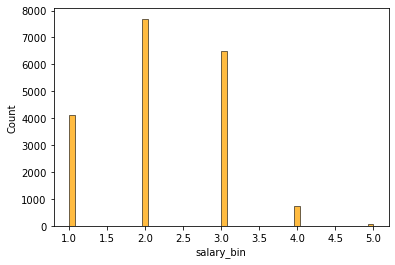

In [138]:
sns.histplot(train['salary_bin'],color="orange");

In [79]:
train['salary_bin'].value_counts()

2    7693
3    6502
1    4121
4     730
5      58
Name: salary_bin, dtype: int64

Most of the employees are receiving salary in the range of 40,000 to 70,000.

In [80]:
train.groupby(['LWD-quarter','salary_bin'])[['LWD-quarter']].count()

LWD-quarter
LWD-quarter salary_bin             
0           1                  3624
            2                  6976
            3                  6124
            4                   707
            5                    57
1           1                   162
            2                   212
            3                    63
            4                     3
2           1                   135
            2                   177
            3                    75
            4                     3
3           1                    98
            2                   177
            3                   106
            4                    10
4           1                   102
            2                   151
            3                   134
            4                     7
            5                     1

Attrition rate among the employees whose salary is above 130,000 is very minimal

In [139]:
# One hot encode the Gender Feature
OHE=pd.get_dummies(train,columns=['Gender'],drop_first=True)

In [146]:
OHE.head()
OHE.shape

,MMM-YY,Emp_ID,Age,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating,Month,DOJ-year,DOJ-quarter,LWD-year,LWD-quarter,salary_bin,Gender_Male
0,2016-01-01,1,28,C23,Master,57387,2015-12-24,NaT,1,1,2381060,2,1,2015,4,0,0,2,1
1,2016-02-01,1,28,C23,Master,57387,2015-12-24,NaT,1,1,-665480,2,2,2015,4,0,0,2,1
2,2016-03-01,1,28,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2,3,2015,4,2016,1,2,1
3,2017-11-01,2,31,C7,Master,67016,2017-11-06,NaT,2,2,0,1,11,2017,4,0,0,2,1
4,2017-12-01,2,31,C7,Master,67016,2017-11-06,NaT,2,2,0,1,12,2017,4,0,0,2,1


(19104, 19)

##### Feature Engineering

#### Create Test DataFrame

In [145]:
test_df=pd.merge(test,OHE,on='Emp_ID',how='left',left_index=True,copy=False)
test_df.shape

(8588, 19)

Generation of Target Variable

The outcome we are looking at is whether the employee will stay with the organization or leave the organization.This can be extracted from the 'Last Working Day' feature. As we are concerned about attrition prediction for the first 2 quarters of the upcoming year.We captured the quarterly attrition data from the 'Last Working Day' feature.  

0: if the employee does not leave the organization
    
1: if the employee leaves the organization

In [82]:
OHE['Target'] = train['LWD-quarter'].apply(lambda x:1 if x != 0 else 0)

In [83]:
OHE['Target'].value_counts()

0    17488
1     1616
Name: Target, dtype: int64

It is an imbalanced Dataset which needs to be balanced.

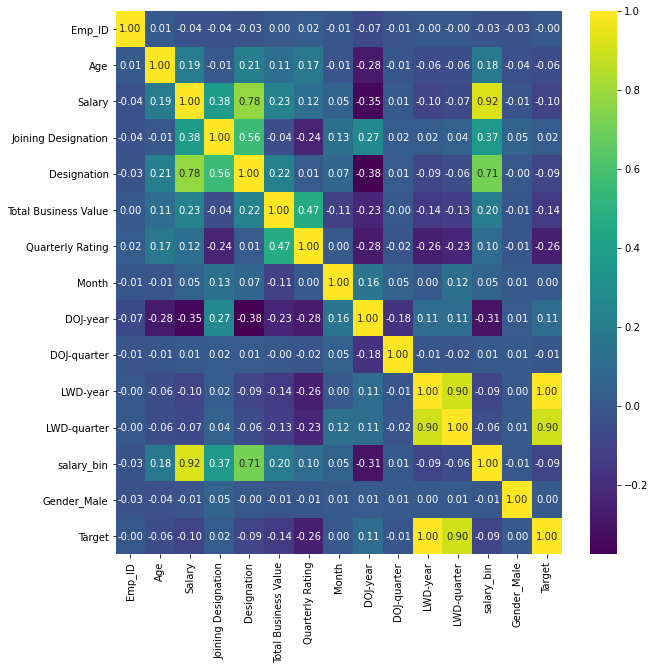

In [84]:
plt.figure(figsize=(10,10))
sns.heatmap(OHE.corr(),annot=True,cmap='viridis',fmt='.2f');

In [85]:
df = OHE.copy()
df.duplicated().sum()

0

In [86]:
X = df.drop(columns=['MMM-YY','City','Education_Level','Dateofjoining','LastWorkingDate','DOJ-year','LWD-quarter','Salary','Designation','Target'],axis=1)
y=df['Target']

In [87]:
X.shape
y.shape
X.head(2)

(19104, 10)

(19104,)

,Emp_ID,Age,Joining Designation,Total Business Value,Quarterly Rating,Month,DOJ-quarter,LWD-year,salary_bin,Gender_Male
0,1,28,1,2381060,2,1,4,0,2,1
1,1,28,1,-665480,2,2,4,0,2,1


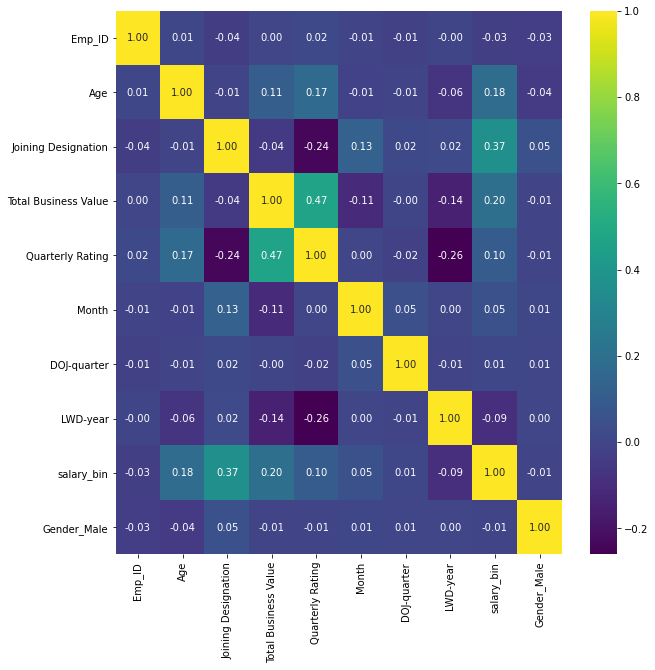

In [88]:
plt.figure(figsize=(10,10))
sns.heatmap(X.corr(),annot=True,cmap='viridis',fmt='.2f');

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 99)
target_percent=pd.DataFrame(y_train.value_counts())
target_percent['percentage']=round((target_percent/target_percent.sum())*100,0)
target_percent

,Target,percentage
0,14017,92.0
1,1266,8.0


#### Sampling Techniques to balance the dataset

1. Undersampling the majority class

In [90]:
train_dff=pd.concat([X_train,y_train],axis=1)
Target_1=train_dff[train_dff['Target']==1]
Target_0=train_dff[train_dff['Target']==0]
Target_1.shape
Target_0.shape

(1266, 11)

(14017, 11)

In [92]:
undersample=resample(Target_0,n_samples=len(Target_1),replace=False,random_state=99)
undersample_train=pd.concat([Target_1,undersample])
undersample_X_train=undersample_train.drop('Target',axis=1)
undersample_y_train=undersample_train['Target']
undersample_X_train.shape
undersample_y_train.shape

(2532, 10)

(2532,)

2. Upsampling the minority class

In [93]:
upsample=resample(Target_1,n_samples=len(Target_0),replace=True,random_state=99)
upsample_train=pd.concat([Target_0,upsample])
upsample_X_train=upsample_train.drop('Target',axis=1)
upsample_y_train=upsample_train['Target']
upsample_X_train.shape
upsample_y_train.shape

(28034, 10)

(28034,)

3. SMOTE- Synthetic Minority Oversampling Technique

In [94]:
sm=SMOTE(sampling_strategy='minority',random_state=99,n_jobs=-1)
sm_X_train,sm_y_train=sm.fit_resample(X_train,y_train)
sm_y_train.value_counts()

1    14017
0    14017
Name: Target, dtype: int64

#### Model Building

In [95]:
def Hyperparameter_tuning(X,y):
    model_params={
        'LogiR':{
            
            'model':LogisticRegression(random_state = 99),
            'Params':{
#                 'penalty': ['elasticnet'],
                'solver': ['saga'], 
                'max_iter': [200], 
                'C':[1.0],
                
            }         
        },
        'SVC':{
            'model':LinearSVC(random_state=99),
            'Params':{
                'C': [1.0],
                'dual': [False],
                'multi_class': ['crammer_singer'],
                'max_iter' : [1500],
                
            }
        },
        'KNN':{
            'model':KNeighborsClassifier(n_jobs=-1),
            'Params':{
                'n_neighbors':[5],
                'metric': ['euclidean'],
                'weights': ['distance'],
                'leaf_size': [40]
            } 
         },
              
        'RForest':{
            'model':RandomForestClassifier(random_state=99,n_jobs=-1),
            'Params':{
                'n_estimators': [150],
                'max_features': [5],
                'max_depth': [6],
                'criterion': ['gini'],
                'max_leaf_nodes': [4],
            }
            
        },
                
        }
      
    CV=ShuffleSplit(n_splits=10,test_size=.20,random_state=99)
    scores=[]
    for key,classifier in model_params.items():
        rscv=RandomizedSearchCV(classifier['model'],classifier['Params'],cv=CV)
        clas_fit=rscv.fit(X,y)
        scores.append({
            'Model':key,
            'Best_Param':clas_fit.best_params_,
            'Best_score':round(clas_fit.best_score_,4)
            
        })
    return pd.DataFrame(scores,columns=['Model','Best_Param','Best_score'])
    

###### Under Sampling

In [99]:
X=undersample_X_train
y=undersample_y_train
X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(X, y, test_size = 0.2, random_state = 99)

In [100]:
Hyperparameter_tuning(X_train_un,y_train_un)

,Model,Best_Param,Best_score
0,LogiR,"{'solver': 'saga', 'max_iter': 200, 'C': 1.0}",0.7993
1,SVC,"{'multi_class': 'crammer_singer', 'max_iter': ...",0.9988
2,KNN,"{'weights': 'distance', 'n_neighbors': 5, 'met...",0.9578
3,RForest,"{'n_estimators': 150, 'max_leaf_nodes': 4, 'ma...",1.0000


In [122]:
SVC=LinearSVC(C=1.0,dual=False,multi_class='crammer_singer',max_iter = 1500,random_state=99)
SVC.fit(X_train_un,y_train_un)
predict=SVC.predict(X_test_un)
features= X.columns
features
coeff=SVC.coef_


LinearSVC(dual=False, max_iter=1500, multi_class='crammer_singer',
          random_state=99)

Index(['Emp_ID', 'Age', 'Joining Designation', 'Total Business Value',
       'Quarterly Rating', 'Month', 'DOJ-quarter', 'LWD-year', 'salary_bin',
       'Gender_Male'],
      dtype='object')

In [123]:
coef = pd.DataFrame(coeff,columns=features)#.sort_values(ascending=False).reset_index(drop=True)
coef


,Emp_ID,Age,Joining Designation,Total Business Value,Quarterly Rating,Month,DOJ-quarter,LWD-year,salary_bin,Gender_Male
0,-0.007557,-0.03115,-0.003236,-0.000002,-0.001195,-0.002707,-0.004253,0.011659,-0.002219,0.000006


In [117]:
print('classification_report:''\n',classification_report(y_test_un,predict))
print('accuracy_score:''\n',accuracy_score(y_test_un,predict))
print('roc_auc_score:''\n',roc_auc_score(y_test_un,predict))
print('recall_score:''\n',recall_score(y_test_un,predict))
print('precision_score:''\n',precision_score(y_test_un,predict))
print('f1_score:''\n',f1_score(y_test_un,predict))

classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       242
           1       1.00      1.00      1.00       265

    accuracy                           1.00       507
   macro avg       1.00      1.00      1.00       507
weighted avg       1.00      1.00      1.00       507

accuracy_score:
 0.9980276134122288
roc_auc_score:
 0.9981132075471698
recall_score:
 0.9962264150943396
precision_score:
 1.0
f1_score:
 0.998109640831758


<Figure size 576x360 with 0 Axes>

<AxesSubplot:>

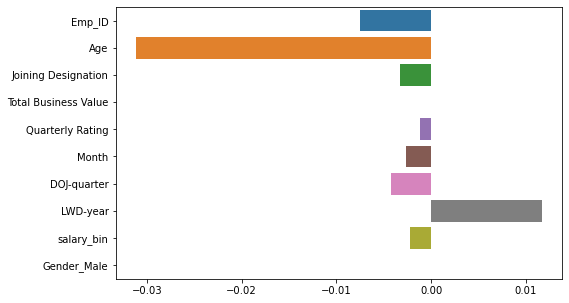

In [124]:
# Barplot for coefficients
plt.figure(figsize=(8,5))
sns.barplot(coeff.flatten(),features)

In [125]:
submission = pd.read_csv('sample_submission_znWiLZ4.csv')
final_predict = SVC.predict(test)
submission['Target'] = final_predict
submission.to_csv('my_submission.csv', index=False)

ValueError: X has 1 features per sample; expecting 10

###### Up_Sampling

In [ ]:
X_train=upsample_X_train
y_train=upsample_y_train
X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(X_train, y_train, test_size = 0.2, random_state = 99)

In [ ]:
models={'LogiR':LogisticRegression(penalty= 'elasticnet',solver= 'saga', max_iter= 200, C=1.0,random_state=99),
        'SVC':LinearSVC(C=1.0,dual=False,multi_class='crammer_singer',max_iter = 1500,random_state=99),
        'KNN':KNeighborsClassifier(n_jobs=-1,n_neighbors=5,metric= 'euclidean',weights = 'distance',leaf_size = 40),
        'RForest':RandomForestClassifier(n_estimators=150,max_features=5,max_depth=6,criterion='gini',random_state=99,n_jobs=-1,max_leaf_nodes = 4)
        }

In [ ]:
def Datefield(x,y,z):
    train['Month'] = pd.to_datetime(train['MMM-YY']).dt.month
    train['LastWorkingDate'] = pd.to_datetime(train['LastWorkingDate'])
    train['Dateofjoining']=pd.to_datetime(train['Dateofjoining'])
    train['DOJ-year'] = train['Dateofjoining'].dt.year
    train['DOJ-quarter'] = train['Dateofjoining'].dt.quarter 
    
    for i in range(len(train['LastWorkingDate'])):
        if train['LastWorkingDate'][i] != 0:
            train['LWD-quarter'] = train['LastWorkingDate'].dt.quarter
            train['LWD-year'] = train['LastWorkingDate'].dt.year
        else:    
            train['LWD-quarter'] = train['LastWorkingDate'].fillna(0)
            train['LWD-year'] = 0
    

In [ ]:
Datefield(train['MMM-YY'],train['Dateofjoining'],train['LastWorkingDate'])

In [ ]:
# train.head(5)

In [ ]:
def Datefield(x,y,z):
    train[x] = pd.to_datetime(x).dt.month
    train[y]=pd.to_datetime(train[y])
    train['DOJ-year'] = train[y].dt.year
    train['DOJ-quarter'] = train[y].dt.quarter
    train[z] = pd.to_datetime(train[z])
    
    for i in range(len(train.shape([0]))):
        if train[z][i] != 0:
            train['LWD-quarter'] = train[z].dt.quarter
            train['LWD-year'] = train[z].dt.year
        else:    
            train['LWD-quarter'] = train[z].fillna(0)
            train['LWD-year'] = 0
            
def date_int(p,q):            
train['LWD-quarter'] = train['LWD-quarter'].fillna(0)
train['LWD-quarter'] = train['LWD-quarter'].astype('int64')
train['LWD-year'] = train['LWD-year'].fillna(0)
train['LWD-year'] = train['LWD-year'].astype('int64')        

In [ ]:
# Datefield('MMM-YY','Dateofjoining','LastWorkingDate')

In [ ]:
Approach for 'LastWorkingDate' field:
    In order to capture the Quarter in which employee left the company, the 'LastWorkingDate' field was converted to date field before filling the NaN values with '0', if '0' is filled before date conversion then the value '0' will be replaced by the default value '1970-01-01'  

In [ ]:
train['LWD-quarter'] = train['LWD-quarter'].fillna(0)
train['LWD-quarter'] = train['LWD-quarter'].astype('int64')
train['LWD-year'] = train['LWD-year'].fillna(0)
train['LWD-year'] = train['LWD-year'].astype('int64') 

In [ ]:
train.head(20)

In [ ]:
train['DOJ-quarter'].dtype

In [129]:
test['Emp_ID'].unique()


In [ ]:
test_set=pd.merge()